In [18]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import re

In [1]:
# 1. Import necessary libraries
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Load the dataset from Hugging Face Hub
print("Loading dataset...")
dataset = load_dataset("zefang-liu/phishing-email-dataset", split="train")
df = dataset.to_pandas()

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

Phishing_Email.csv:   0%|          | 0.00/52.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18650 [00:00<?, ? examples/s]

In [2]:
# Drop any rows with missing values to ensure data quality
df.dropna(inplace=True)
# Rename columns for easier access
df.rename(columns={"Email Text": "text", "Email Type": "label"}, inplace=True)

print(f"Dataset loaded successfully with {len(df)} emails.")
print("\nDataset Info:")
df.info()
print("\nClass Distribution:")
print(df['label'].value_counts())


# 3. Preprocess the Data
# Separate features (X) and target (y)
X = df['text']
y = df['label']

Dataset loaded successfully with 18634 emails.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 18634 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18634 non-null  int64 
 1   text        18634 non-null  object
 2   label       18634 non-null  object
dtypes: int64(1), object(2)
memory usage: 582.3+ KB

Class Distribution:
label
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64


In [3]:
# Create a TF-IDF Vectorizer to convert text into numerical features.
# TF-IDF (Term Frequency-Inverse Document Frequency) is a standard technique
# for text classification that reflects how important a word is to a document.
print("\nVectorizing text data...")
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_tfidf = vectorizer.fit_transform(X)
print("Vectorization complete.")


# 4. Split Data into Training and Testing Sets
# We'll use 80% of the data for training and 20% for testing.
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]} emails")
print(f"Test set size: {X_test.shape[0]} emails")


Vectorizing text data...
Vectorization complete.

Splitting data into training and testing sets...
Training set size: 14907 emails
Test set size: 3727 emails


In [4]:
# 5. Train the Machine Learning Model
# We will use the Multinomial Naive Bayes algorithm, which is highly
# effective and efficient for text classification tasks like this one.
print("\nTraining the Naive Bayes classifier...")
model = MultinomialNB()
model.fit(X_train, y_train)
print("Model training complete.")


# 6. Evaluate the Model
print("\nEvaluating the model...")
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")


Training the Naive Bayes classifier...
Model training complete.

Evaluating the model...

Model Accuracy: 0.9289



Classification Report:
                precision    recall  f1-score   support

Phishing Email       1.00      0.82      0.90      1462
    Safe Email       0.90      1.00      0.94      2265

      accuracy                           0.93      3727
     macro avg       0.95      0.91      0.92      3727
  weighted avg       0.94      0.93      0.93      3727


Confusion Matrix:


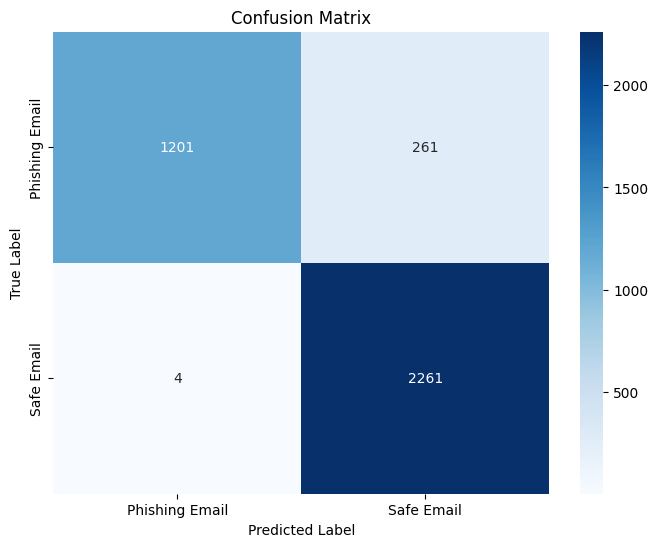

In [5]:
# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display a confusion matrix to visualize performance
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Phishing Email', 'Safe Email'],
            yticklabels=['Phishing Email', 'Safe Email'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [6]:
# 7. Test with a new email example
def predict_email(email_text):
    """
    Takes a new email text as input, preprocesses it, and predicts
    if it's phishing or safe.
    """
    # Vectorize the new email text using the same vectorizer
    email_tfidf = vectorizer.transform([email_text])
    # Predict the label
    prediction = model.predict(email_tfidf)
    # Predict the probabilities for each class
    probabilities = model.predict_proba(email_tfidf)

    return prediction[0], probabilities[0]

In [7]:
# Example emails to test
phishing_example = "Subject: Urgent account verification required! Click here to update your details now or your account will be suspended."
safe_example = "Subject: Meeting Reminder. Hi team, just a reminder about our quarterly review meeting tomorrow at 10 AM. Please find the agenda attached."

# Predict the phishing example
pred_label, pred_probs = predict_email(phishing_example)
print(f"\n--- Testing with a new email ---")
print(f"Email Text: '{phishing_example}'")
print(f"Predicted Label: {pred_label}")
print(f"Probabilities: [Phishing: {pred_probs[0]:.2f}, Safe: {pred_probs[1]:.2f}]")

# Predict the safe example
pred_label, pred_probs = predict_email(safe_example)
print(f"\n--- Testing with another new email ---")
print(f"Email Text: '{safe_example}'")
print(f"Predicted Label: {pred_label}")
print(f"Probabilities: [Phishing: {pred_probs[0]:.2f}, Safe: {pred_probs[1]:.2f}]")




--- Testing with a new email ---
Email Text: 'Subject: Urgent account verification required! Click here to update your details now or your account will be suspended.'
Predicted Label: Phishing Email
Probabilities: [Phishing: 0.71, Safe: 0.29]

--- Testing with another new email ---
Email Text: 'Subject: Meeting Reminder. Hi team, just a reminder about our quarterly review meeting tomorrow at 10 AM. Please find the agenda attached.'
Predicted Label: Safe Email
Probabilities: [Phishing: 0.01, Safe: 0.99]


In [8]:
# 8. Save the Model and Vectorizer to Disk
import pickle

print("\nSaving the trained model and vectorizer to disk...")

# Define filenames for the model and vectorizer
model_filename = 'phishing_detector_model_naive.pkl'
vectorizer_filename = 'tfidf_vectorizer.pkl'

# Save the Linear SVC model
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)
print(f"Model saved successfully as '{model_filename}'")

# Save the TF-IDF vectorizer
with open(vectorizer_filename, 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)
print(f"Vectorizer saved successfully as '{vectorizer_filename}'")




Saving the trained model and vectorizer to disk...
Model saved successfully as 'phishing_detector_model_naive.pkl'
Vectorizer saved successfully as 'tfidf_vectorizer.pkl'


In [9]:
# load_and_predict.py

import pickle

# 1. Load the saved model and vectorizer from disk
print("Loading model and vectorizer...")
with open('phishing_detector_model_naive.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open('tfidf_vectorizer_naive.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)
print("Loading complete.")


# 2. Define a function to make predictions
def predict_email_from_file(email_text):
    """
    Takes new email text, transforms it using the loaded vectorizer,
    and predicts the class using the loaded model.
    """
    # Transform the new email text using the loaded vectorizer
    email_tfidf = loaded_vectorizer.transform([email_text])

    # Predict the label using the loaded model
    prediction = loaded_model.predict(email_tfidf)

    # For models that support it, you can also get probabilities
    # Note: LinearSVC with default settings doesn't directly output probabilities.
    # To get them, you'd need to wrap it in CalibratedClassifierCV before training.
    # For now, we'll just return the direct prediction.

    return prediction[0]

# 3. Test with new email examples
phishing_example = "Subject: Package Delivery Attempted – Action Required"
safe_example = "Subject: Your order has shipped! Hi John, we're happy to let you know that your order #12345 has shipped. You can track it here."

# Predict the phishing example
prediction = predict_email_from_file(phishing_example)
print(f"\n--- Testing a new email ---")
print(f"Email Text: '{phishing_example}'")
print(f"Predicted Label: {prediction}")

# Predict the safe example
prediction = predict_email_from_file(safe_example)
print(f"\n--- Testing another new email ---")
print(f"Email Text: '{safe_example}'")
print(f"Predicted Label: {prediction}")


Loading model and vectorizer...
Loading complete.

--- Testing a new email ---
Email Text: 'Subject: Package Delivery Attempted – Action Required'
Predicted Label: Safe Email

--- Testing another new email ---
Email Text: 'Subject: Your order has shipped! Hi John, we're happy to let you know that your order #12345 has shipped. You can track it here.'
Predicted Label: Safe Email


SUPPORT VECTOR. MACHINE

In [10]:
# 5. Train the Machine Learning Model (Using Linear SVC)
from sklearn.svm import LinearSVC

print("\nTraining the Linear Support Vector Classifier (SVC)...")

# Initialize the LinearSVC model.
# The 'C' parameter is a regularization parameter. A smaller C encourages a
# simpler model, while a larger C tries to fit the training data as well as possible.
# 'max_iter' is increased to ensure the model converges.
model_svc = LinearSVC(C=1.0, random_state=42, max_iter=2000)

# Train the model on the training data
model_svc.fit(X_train, y_train)
print("Model training complete.")


Training the Linear Support Vector Classifier (SVC)...
Model training complete.


In [11]:
# 6. Evaluate the Model
print("\nEvaluating the Linear SVC model...")
# Make predictions on the test set
y_pred_svc = model_svc.predict(X_test)

# Calculate accuracy
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"\nLinear SVC Model Accuracy: {accuracy_svc:.4f}")



Evaluating the Linear SVC model...

Linear SVC Model Accuracy: 0.9807



Classification Report (Linear SVC):
                precision    recall  f1-score   support

Phishing Email       0.96      0.99      0.98      1462
    Safe Email       0.99      0.97      0.98      2265

      accuracy                           0.98      3727
     macro avg       0.98      0.98      0.98      3727
  weighted avg       0.98      0.98      0.98      3727


Confusion Matrix (Linear SVC):


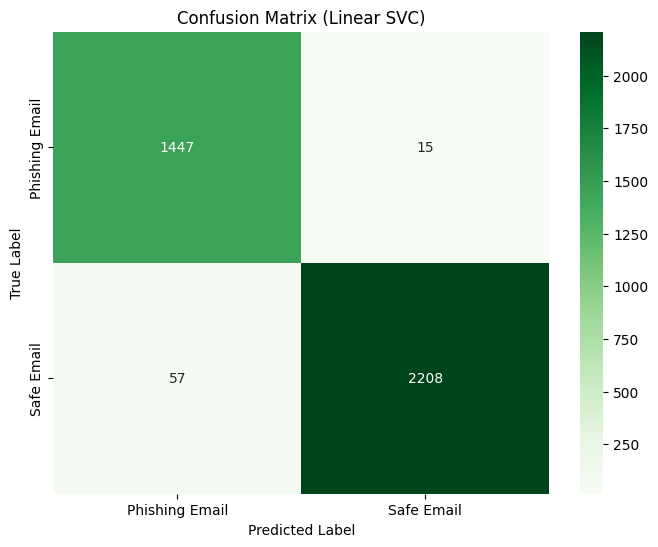

In [12]:

# Display a detailed classification report
print("\nClassification Report (Linear SVC):")
print(classification_report(y_test, y_pred_svc))

# Display a confusion matrix
print("\nConfusion Matrix (Linear SVC):")
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Phishing Email', 'Safe Email'],
            yticklabels=['Phishing Email', 'Safe Email'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Linear SVC)')
plt.show()

In [13]:
# 8. Save the Model and Vectorizer to Disk
import pickle

print("\nSaving the trained model and vectorizer to disk...")

# Define filenames for the model and vectorizer
model_filename = 'phishing_detector_model_svc.pkl'
vectorizer_filename = 'tfidf_vectorizer_svc.pkl'

# Save the Linear SVC model
with open(model_filename, 'wb') as model_file:
    pickle.dump(model_svc, model_file)
print(f"Model saved successfully as '{model_filename}'")

# Save the TF-IDF vectorizer
with open(vectorizer_filename, 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)
print(f"Vectorizer saved successfully as '{vectorizer_filename}'")




Saving the trained model and vectorizer to disk...
Model saved successfully as 'phishing_detector_model_svc.pkl'
Vectorizer saved successfully as 'tfidf_vectorizer_svc.pkl'


In [15]:
# 1. Load the saved model and vectorizer from disk
print("Loading model and vectorizer...")
with open('phishing_detector_model_svc.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

with open('tfidf_vectorizer_svc.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)
print("Loading complete.")


# 2. Define a function to make predictions
def predict_email_from_file(email_text):
    """
    Takes new email text, transforms it using the loaded vectorizer,
    and predicts the class using the loaded model.
    """
    # Transform the new email text using the loaded vectorizer
    email_tfidf = loaded_vectorizer.transform([email_text])

    # Predict the label using the loaded model
    prediction = loaded_model.predict(email_tfidf)

    # For models that support it, you can also get probabilities
    # Note: LinearSVC with default settings doesn't directly output probabilities.
    # To get them, you'd need to wrap it in CalibratedClassifierCV before training.
    # For now, we'll just return the direct prediction.

    return prediction[0]

# 3. Test with new email examples
phishing_example = "Subject: Package Delivery Attempted – Action Required"
safe_example = "Subject: Your order has shipped! Hi John, we're happy to let you know that your order #12345 has shipped. You can track it here."

# Predict the phishing example
prediction = predict_email_from_file(phishing_example)
print(f"\n--- Testing a new email ---")
print(f"Email Text: '{phishing_example}'")
print(f"Predicted Label: {prediction}")

# Predict the safe example
prediction = predict_email_from_file(safe_example)
print(f"\n--- Testing another new email ---")
print(f"Email Text: '{safe_example}'")
print(f"Predicted Label: {prediction}")


Loading model and vectorizer...
Loading complete.

--- Testing a new email ---
Email Text: 'Subject: Package Delivery Attempted – Action Required'
Predicted Label: Phishing Email

--- Testing another new email ---
Email Text: 'Subject: Your order has shipped! Hi John, we're happy to let you know that your order #12345 has shipped. You can track it here.'
Predicted Label: Phishing Email


**Adding more sophisticated features**

**Step 1:**  Engineering Advanced Text Features
Relying only on word frequencies (TF-IDF) is powerful, but phishing emails often have other tell-tale signs that aren't just about the words they use. We can capture these signs by creating new, metadata-based features from the email text.
Here are some highly effective features for phishing detection:
1.   Text Length: Phishing emails are often unusually short or long.
2.   Number of Digits: They frequently contain strings of numbers (e.g., "Your account number 12345...").
3.  Number of Uppercase Characters: Excessive capitalization can create a false sense of urgency ("URGENT ACTION REQUIRED").
4. Presence of "Subject:": While most emails have a subject, its absence or format can be a feature.
5.  Number of "Suspicious" Words: We can create a list of common phishing keywords (e.g., "urgent," "verify," "account," "password," "winner") and count their occurrences.
    

    
    
    


In [16]:
# --- 2. Define Feature Engineering Functions ---
print("Defining feature engineering functions...")
# Count suspicious keywords often found in phishing emails
def count_suspicious_words(text):
    suspicious_keywords = [
        'urgent', 'verify', 'account', 'password', 'credit', 'card', 'winner',
        'congratulations', 'claim', 'prize', 'suspend', 'confirm', 'login', 'bank'
    ]
    count = 0
    for word in suspicious_keywords:
        if word in text.lower():
            count += 1
    return count

# --- 3. Apply Feature Engineering ---
print("Applying feature engineering...")
df['text_length'] = df['text'].apply(len)
df['digit_count'] = df['text'].apply(lambda s: sum(c.isdigit() for c in s))
df['upper_count'] = df['text'].apply(lambda s: sum(c.isupper() for c in s))
df['suspicious_word_count'] = df['text'].apply(count_suspicious_words)

# --- 4. Define Preprocessing Pipeline ---
print("Defining preprocessing pipeline...")
# Define the new numerical features we created
numeric_features = ['text_length', 'digit_count', 'upper_count', 'suspicious_word_count']
# Define the text feature
text_feature = 'text'

Defining feature engineering functions...
Applying feature engineering...
Defining preprocessing pipeline...


In [19]:
# Create a preprocessor object using ColumnTransformer
# This applies different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), # Scale numeric features
        ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7), text_feature) # Vectorize text
    ],
    remainder='drop' # Drop any other columns
)

# --- 5. Create and Train the Full Pipeline ---
# A pipeline chains the preprocessor and the model together.
# This makes it easy to manage the entire workflow.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(C=1.0, random_state=42, max_iter=2000))
])

# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
# Train the entire pipeline
print("\nTraining the model with advanced features...")
model_pipeline.fit(X_train, y_train)
print("Training complete.")

# --- 6. Evaluate the New Model ---
print("\nEvaluating the enhanced model...")
y_pred = model_pipeline.predict(X_test)
print("\nClassification Report (Enhanced Model):")
print(classification_report(y_test, y_pred))

# --- 7. Save the Final Pipeline ---
# Now we only need to save ONE object: the entire pipeline.
# It contains the feature engineering, preprocessing, and the trained model.
pipeline_filename = 'phishing_detection_pipeline_feature_eng.pkl'
print(f"\nSaving the complete pipeline to '{pipeline_filename}'...")
with open(pipeline_filename, 'wb') as f:
    pickle.dump(model_pipeline, f)
print("Pipeline saved successfully.")


Training the model with advanced features...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training complete.

Evaluating the enhanced model...

Classification Report (Enhanced Model):
                precision    recall  f1-score   support

Phishing Email       0.96      0.99      0.98      1462
    Safe Email       0.99      0.98      0.98      2265

      accuracy                           0.98      3727
     macro avg       0.98      0.98      0.98      3727
  weighted avg       0.98      0.98      0.98      3727


Saving the complete pipeline to 'phishing_detection_pipeline_feature_eng.pkl'...
Pipeline saved successfully.
